In [5]:
import pandas as pd 
import torch
train_data = pd.read_excel('/kaggle/input/adobe-nlp/behaviour_simulation_train.xlsx',index_col='id')

In [6]:
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2

# Define a function that converts images to 3 channels
def to_three_channels(image, **kwargs):
    # Check the number of channels in the image 
    if image.shape[2] == 1:  # Grayscale image
        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:  # RGBA image
        return cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    return image  # Already 3 channels

# Define the transformation pipeline
transformation = A.Compose([
    A.Lambda(image=to_three_channels),  # Use the custom function to convert to 3 channels
    A.Resize(224, 224),                  # Resize the image
    A.Normalize(),                       # Normalize pixel values
    ToTensorV2()                        # Convert to PyTorch tensor
])

# Example usage
# Assuming you have an image in the variable `image`
# transformed_image = transformation(image=image)["image"]

In [7]:
group = train_data['inferred company']
from sklearn.model_selection import GroupKFold
gkf = GroupKFold()

In [8]:
feature_col = ['date','content', 'username', 'media', 'inferred company']
target_col = ['likes']

In [9]:
for i,j in gkf.split(train_data,groups=group):
    train= train_data[feature_col+target_col].iloc[i]
    val= train_data[feature_col+target_col].iloc[j] 

In [63]:
from torch.utils.data import Dataset,DataLoader

class dataset(Dataset):
    def __init__(self,df,transformation):
        super().__init__()
        self.lst = df['media']
        self.y = df['likes']
        self.transform = transformation
    def __len__(self):
        return len(self.lst)

    def __getitem__(self,index):
        photo_pattern = r"Photo\(previewUrl='(.*?)',"
        thumbnail_pattern = r"thumbnailUrl='(.*?)',"
        photo_urls = re.findall(photo_pattern, self.lst.iloc[index])
        thumbnail_urls = re.findall(thumbnail_pattern, self.lst.iloc[index])
        if len(photo_urls)==1 :
            url = photo_urls
        elif len(thumbnail_urls)==1:
            url = thumbnail_urls
        else:
            url = 'https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.istockphoto.com%2Fphotos%2Fwhite-material&psig=AOvVaw2TO_EWU6OzVoSEWBWfqgpk&ust=1728752656403000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCKDO79HnhokDFQAAAAAdAAAAABAG'
        
        try: 
            response = requests.get(url[0])
            with open(f'image/{index}.jpg','wb') as file:
                file.write(response.content)
            img = Image.open(f'image/{index}.jpg')
        except:
            img = Image.open(f'/kaggle/input/whiteimg/images.jpeg')
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        # img = np.transpose(img, (2, 0, 1))
        return img,self.y.iloc[index]

In [74]:
train_dataset = dataset(train,transformation)
val_dataset = dataset(val,transformation)

In [75]:
import os
train_loader = DataLoader(dataset=train_dataset,batch_size=32,num_workers=4,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=32,num_workers=4,shuffle=False)

In [76]:
import torchvision.models as models
fnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

In [77]:
from torch import nn
class embeddings(nn.Module):
    def __init__(self):
        super().__init__()
        self.fnet = fnet
        self.fc = nn.Sequential(nn.Linear(1000,256),nn.ReLU(),nn.Linear(256,1))
        for param in self.fnet.parameters():
            param.requires_grad=False
        for param in self.fc.parameters():
            param.requires_grad=True
    def forward(self,x):
        x = self.fnet(x)
        return self.fc(x)
effnet = embeddings()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [78]:
import torch
from torch import nn
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(effnet.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2,factor=0.1)

In [79]:
import tqdm
import re
from PIL import Image
epochs = 10
effnet = effnet.to(device)
effnet = effnet.to(float)
bigl = []
bigl2 =[]
for epoch in (range(epochs)):
    effnet.train()
    l = []
    for i,j in tqdm.tqdm(train_loader):
        i = i.to(float).to(device)
        j = j.to(float).to(device)
        y_pred = effnet(i)
        loss = loss_fn(y_pred.squeeze(),j)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l.append(loss.item())
    bigl.append(np.mean(l))
    effnet.eval()
    l2 = []
    for i,j in tqdm.tqdm(val_loader):
        i = i.to(float).to(device)
        j = j.to(float).to(device)
        y_pred = effnet(i)
        loss = loss_fn(y_pred.squeeze(),j)
        l2.append(loss.item())
    bigl2.append(np.mean(l2))
    print(f"Train loss : {bigl[-1]} | Val loss : {bigl2[-1]}")
    scheduler.step(bigl2[-1])

100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


Train loss : 2309.363167406533 | Val loss : 2728.0146517736766


100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


Train loss : 2305.1684256795443 | Val loss : 2719.3151767936224


100%|██████████| 32/32 [00:05<00:00,  5.74it/s]


Train loss : 2312.0538534514812 | Val loss : 2716.1377514369433


100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


Train loss : 2310.3650712350845 | Val loss : 2722.030710578281


100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


Train loss : 2299.9768528634177 | Val loss : 2731.1898599539372


100%|██████████| 32/32 [00:05<00:00,  5.73it/s]


Train loss : 2311.489756506099 | Val loss : 2720.480063713766


100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


Train loss : 2310.774586374595 | Val loss : 2723.678942473147


100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


Train loss : 2316.061966845911 | Val loss : 2723.6024448966623


100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


Train loss : 2306.749411642944 | Val loss : 2722.4268492212905


100%|██████████| 32/32 [00:05<00:00,  5.72it/s]

Train loss : 2287.916965202114 | Val loss : 2722.7486438371884


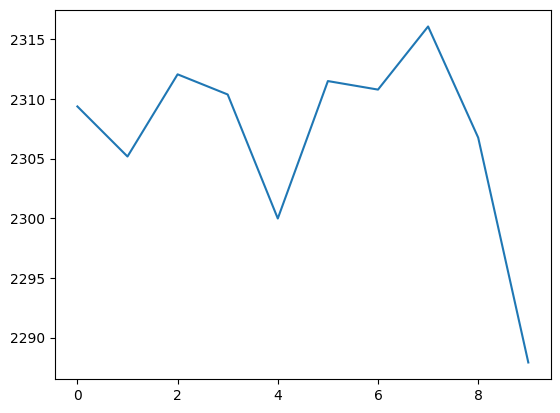

In [80]:
import matplotlib.pyplot as plt
plt.plot(bigl)

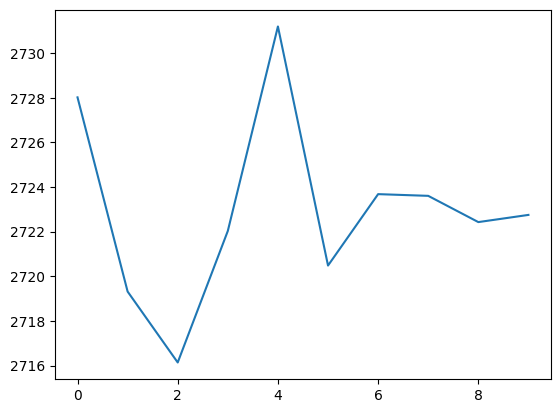

In [81]:
plt.plot(bigl2)

In [82]:
torch.save(effnet.state_dict(),'effnet-full-trained.pth')

NameError: name 'h' is not defined